### Denoising

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import mnist

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [11]:
import matplotlib.pyplot as plt

### Preprocessing

In [6]:
(x_train_fs,_), (x_test_fs,_)= fashion_mnist.load_data()

In [7]:
(x_train_n,_), (x_test_n,_)= mnist.load_data()

In [8]:
x_train_n = x_train_n.astype('float32') / 255
x_test_n = x_test_n.astype('float32') / 255

In [9]:
x_train_fs = x_train_fs.astype('float32') / 255
x_test_fs = x_test_fs.astype('float32') / 255

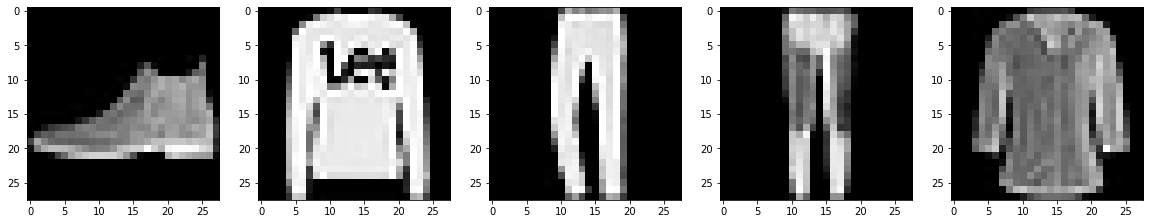

In [12]:
count=5
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test_fs[i].reshape(28, 28))
    plt.gray()
    
plt.show()
    

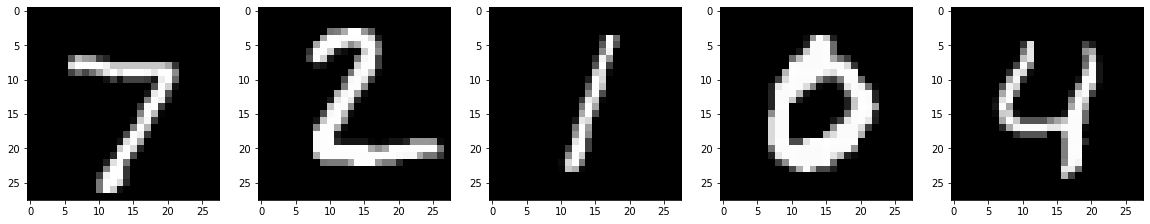

In [13]:
count=5
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test_n[i].reshape(28, 28))
    plt.gray()
    
plt.show()
    

In [14]:
import numpy as np

In [15]:
x_train_fs = x_train_fs[..., tf.newaxis]
x_test_fs = x_test_fs[..., tf.newaxis]

In [16]:
x_train_fs.shape

(60000, 28, 28, 1)

In [17]:
x_train_n = x_train_n[..., tf.newaxis]
x_test_n = x_test_n[..., tf.newaxis]

In [18]:
x_train_n.shape

(60000, 28, 28, 1)

### Noise creation

In [24]:
noise_factor = 0.3
x_train_fs_noisy = x_train_fs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_fs.shape) 
x_test_fs_noisy = x_test_fs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_fs.shape) 

x_train_fs_noisy = np.clip(x_train_fs_noisy, 0., 1.)
x_test_fs_noisy = np.clip(x_test_fs_noisy, 0., 1.)

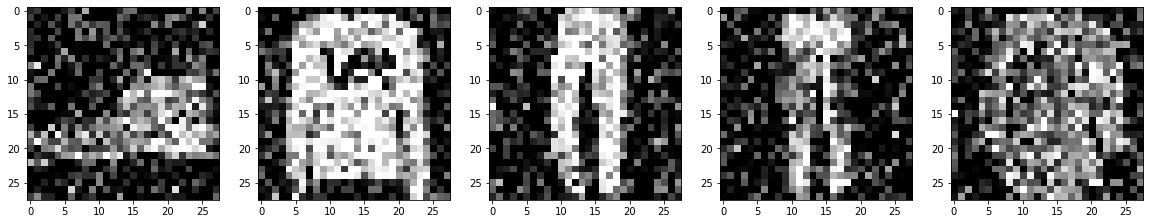

In [25]:
count=5
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test_fs_noisy[i].reshape(28, 28))
    plt.gray()
    
plt.show()
    

In [28]:
noise_factor = 0.5
x_train_n_noisy = x_train_n + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_n.shape) 
x_test_n_noisy = x_test_n + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_n.shape) 

x_train_n_noisy = np.clip(x_train_n_noisy, 0., 1.)
x_test_n_noisy = np.clip(x_test_n_noisy, 0., 1.)

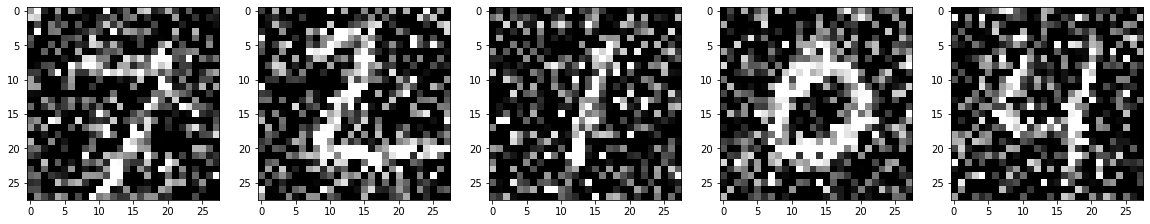

In [29]:
count=5
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test_n_noisy[i].reshape(28, 28))
    plt.gray()
    
plt.show()

### Modelling

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

In [31]:
input_l=Input(shape=(28,28,1))

encoding_1=Conv2D(32, (3,3), activation='relu',padding='same')(input_l)
maxp_1=MaxPooling2D((2,2), padding='same')(encoding_1)

encoding_2=Conv2D(16, (3,3), activation='relu',padding='same')(maxp_1)
maxp_2=MaxPooling2D((2,2), padding='same')(encoding_2)

encoding_3=Conv2D(8, (3,3), activation='relu',padding='same')(maxp_2)

bottleneck=MaxPooling2D((2,2), padding='same')(encoding_3)

decoding_1=Conv2D(8, (3,3), activation='relu', padding='same')(bottleneck)
Up_1=UpSampling2D((2,2))(decoding_1)


decoding_2=Conv2D(16, (3,3), activation='relu', padding='same')(Up_1)
Up_2=UpSampling2D((2,2))(decoding_2)

decoding_3=Conv2D(32, (3,3), activation='relu')(Up_2)
Up_3=UpSampling2D((2,2))(decoding_3)

output_l= Conv2D(1,(3,3),activation='sigmoid',padding='same')(Up_3)

autoencoder=Model(inputs=[input_l],outputs=[output_l])

In [32]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [33]:
encoder=Model(inputs=[input_l],outputs=[bottleneck])

In [34]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [35]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')